# Port Seguro's Safe Driver Prediction

## Overview

Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drive.

Link: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

## Imports

In [4]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Machine learning
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

# Other
from IPython.display import Image
import configparser
import gc # clear RAM
import warnings
import time
import os
import subprocess

### Prepare Principal Directory

In [5]:
def prepare_directory_work(end_directory: str='notebooks'):
    # Current path
    curr_dir = os.path.dirname (os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}'

In [6]:
prepare_directory_work(end_directory='notebooks')

'/home/campos/projetos/challenges/kaggle/porto-seguro-safe-driver-prediction/notebooks'

### Prepare Environment

In [9]:
# from <package>.<module> import <class>
from src.environment.prepare_env import *


main()

Requirements this project:


--------------------------------------------------
Configuration Environment:

OS:
Linux
Distributor ID:	Ubuntu
Description:	Ubuntu 19.04
Release:	19.04
Codename:	disco

Python Version:
Python 3.7.3

Pip Version:
pip 19.1.1 from /home/campos/projetos/venv_global/lib/python3.7/site-packages/pip (python 3.7)

Jupyter Version:
jupyter core     : 4.5.0
jupyter-notebook : 5.7.8
qtconsole        : 4.5.1
ipython          : 7.5.0
ipykernel        : 5.1.1
jupyter client   : 5.2.4
jupyter lab      : not installed
nbconvert        : 5.5.0
ipywidgets       : 7.4.2
nbformat         : 4.4.0
traitlets        : 4.3.2

--------------------------------------------------

Disk Usage:

data:
359M	data/

virtual env:

all:
439M	.

--------------------------------------------------
Structure This Project:

.
├── data
│   ├── datasets.zip
│   ├── sample_submission.csv
│   ├── test.csv
│   └── train.csv
├── LICENSE
├── notebooks
│   └── porto_seguro_safe_driver.ipynb
├── README.md

### Cell Format
Cell format graphics and tables.

In [28]:
# Guarantees visualization inside the jupyter
%matplotlib inline

# formata os dados de todas as tabelas (ponto flutuante com 2 casas)
pd.options.display.float_format = '{:.2f}'.format

# parametros de config
rc={'savefig.dpi': 75, 
    'figure.autolayout': False, 
    'figure.figsize': [15, 8], 
    'axes.labelsize': 18,
    'axes.titlesize': 18, 
    'font.size': 18, 
    'lines.linewidth': 2.0, 
    'lines.markersize': 8, 
    'legend.fontsize': 16,
    'xtick.labelsize': 16, 
    'ytick.labelsize': 16}

# Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

# Definition color and map de colors
default_color = '#56B4E9'
colormap = plt.cm.cool

# Single colour palettes for good and bad outcomes
good_palette = ['#44cc44']
bad_palette = ['#cc4444']
# Colour palette for gender - traditional light pink (female), light blue (male)
gender_palette = ['#B0C4DE','#FFB6C1']
# Colour palette for ticket class - gold (first), silver (second), bronze (third)
class_palette = ['#FFD700','#C0C0C0','#CD7F32']

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# graph style
sns.set(style='dark',rc=rc)

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Description
In this competition, you will predict the probability that an auto insurance policy holder files a claim.
In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal.
- Values of -1 indicate that the feature was _missing_ from the observation.
- `target` columns signifies whether or not a claim was filed for that policy holder.
- `Ind` is related to individual or driver
- `reg` is related to region
- `car` is related to car itself
- `calc` is an calculated feature


## File descriptions
- `train.csv` contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.
- `test.csv` contains the test data.
- `sample_submission.csv` is submission file showing the correct format.




## Loding files

In [10]:
%%time

# sep=','
# na_values = valores nulos
# encoding='utf-8'

train = pd.read_csv('data/train.csv', 
                    na_values=-1,
                    sep=',',
                    encoding='utf-8')
test = pd.read_csv('data/test.csv', 
                   na_values=-1,
                   sep=',',
                   encoding='utf-8')

CPU times: user 7.21 s, sys: 582 ms, total: 7.8 s
Wall time: 8.78 s


## Data analysis 

In [11]:
# Required column for kaggle submition
id_test = test['id'].values

In [12]:
print(train.shape)
print(test.shape)

(595212, 59)
(892816, 58)


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     594996 non-null float64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595129 non-null float64
ps_ind_05_cat     589403 non-null float64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 58 columns):
id                892816 non-null int64
ps_ind_01         892816 non-null int64
ps_ind_02_cat     892509 non-null float64
ps_ind_03         892816 non-null int64
ps_ind_04_cat     892671 non-null float64
ps_ind_05_cat     884106 non-null float64
ps_ind_06_bin     892816 non-null int64
ps_ind_07_bin     892816 non-null int64
ps_ind_08_bin     892816 non-null int64
ps_ind_09_bin     892816 non-null int64
ps_ind_10_bin     892816 non-null int64
ps_ind_11_bin     892816 non-null int64
ps_ind_12_bin     892816 non-null int64
ps_ind_13_bin     892816 non-null int64
ps_ind_14         892816 non-null int64
ps_ind_15         892816 non-null int64
ps_ind_16_bin     892816 non-null int64
ps_ind_17_bin     892816 non-null int64
ps_ind_18_bin     892816 non-null int64
ps_reg_01         892816 non-null float64
ps_reg_02         892816 non-null float64
ps_reg_03         731132 non-null float

In [15]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [16]:
test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1.0,8,1.0,0.0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2.0,5,1.0,0.0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1.0,3,0.0,0.0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1.0,6,0.0,0.0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1.0,7,0.0,0.0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


## Target Analisys
This column signifies whether or not a claim was filed for that policy holder.
- Go claim
- Dont claim

**OBS:** never use target how feature

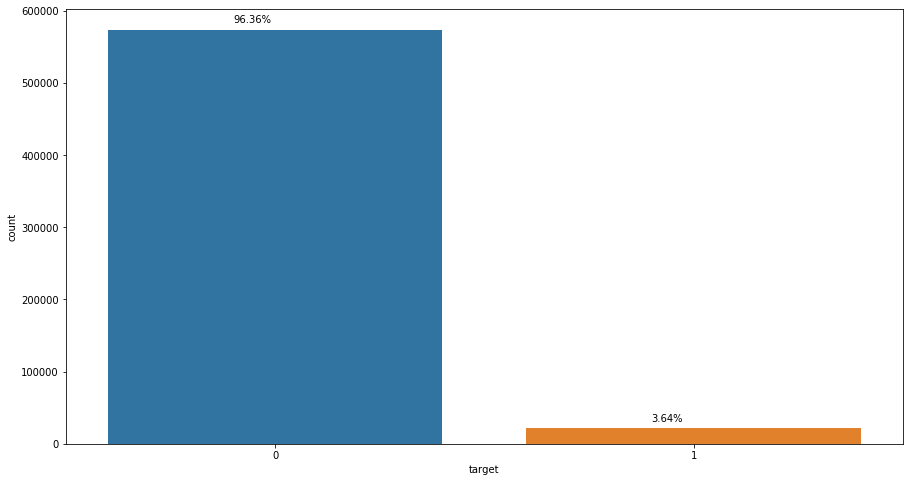

In [18]:
plt.figure(figsize=(15,8))

# faz um agrupamento da coluna 'target'
ax = sns.countplot('target', data=train)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(train['target'])), 
                (p.get_x() + 0.3, p.get_height() + 10000))

Only 3.64% a clain

# Data Analisys

In [19]:
def get_meta(train):
    data = []
    for col in train.columns:
        # Defining the role
        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'input'

        # Defining the level
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col or col == 'id':
            level = 'nominal'
        elif train[col].dtype == np.float64:
            level = 'interval'
        elif train[col].dtype == np.int64:
            level = 'ordinal'

        # Initialize keep to True for all variables except for id
        keep = True
        if col == 'id':
            keep = False

        # Defining the data type 
        dtype = train[col].dtype

        # Creating a Dict that contains all the metadata for the variable
        col_dict = {
            'varname': col,
            'role'   : role,
            'level'  : level,
            'keep'   : keep,
            'dtype'  : dtype
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
    meta.set_index('varname', inplace=True)
    return meta

In [ ]:
meta_data = get_meta(train)
display(meta_data)

In [21]:
meta_counts = meta_data\
                    .groupby(['role', 'level'])\
                        .agg({'dtype': lambda x: x.count()})\
                            .reset_index()
display(meta_counts)

,role,level,dtype
0,id,nominal,1
1,input,binary,17
2,input,interval,11
3,input,nominal,14
4,input,ordinal,15
5,target,binary,1


[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Variable Type'),
 Text(0.5, 1.0, 'Variables Count Across Datatype')]

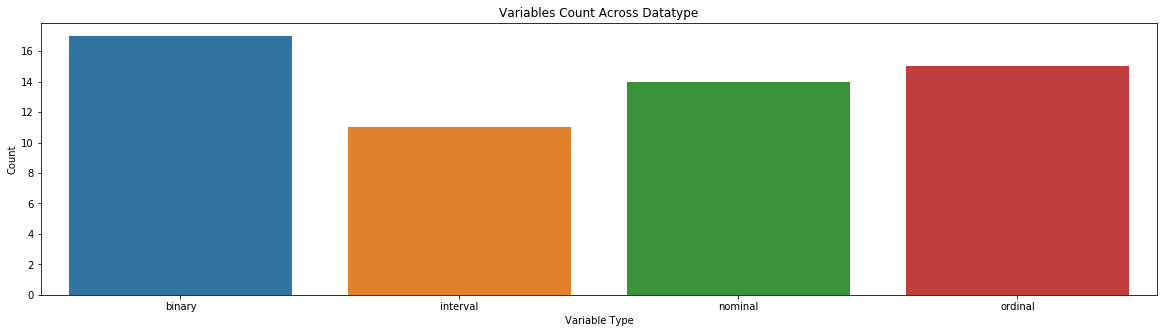

In [23]:
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sns.barplot(data=meta_counts[(meta_counts.role != 'target') & (meta_counts.role != 'id') ],
            x="level",
            y="dtype",
            ax=ax)

ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

In [24]:
col_ordinal   = meta_data[(meta_data.level == 'ordinal') & (meta_data.keep)].index
col_nominal   = meta_data[(meta_data.level == 'nominal') & (meta_data.keep)].index
col_internval = meta_data[(meta_data.level == 'interval') & (meta_data.keep)].index
col_binary    = meta_data[(meta_data.level == 'binary') & (meta_data.keep) & (meta_data.role != 'target')].index

---

# Missing Values

Há 2 tipos de missing:
- ausência de dados
- Inferência de negados: como se comportaria um cliente se for negado.

In [25]:
# return TRUE se a coluna tem pelo menos um values missing
train.isnull().any()

id                False
target            False
ps_ind_01         False
ps_ind_02_cat      True
ps_ind_03         False
ps_ind_04_cat      True
ps_ind_05_cat      True
ps_ind_06_bin     False
ps_ind_07_bin     False
ps_ind_08_bin     False
ps_ind_09_bin     False
ps_ind_10_bin     False
ps_ind_11_bin     False
ps_ind_12_bin     False
ps_ind_13_bin     False
ps_ind_14         False
ps_ind_15         False
ps_ind_16_bin     False
ps_ind_17_bin     False
ps_ind_18_bin     False
ps_reg_01         False
ps_reg_02         False
ps_reg_03          True
ps_car_01_cat      True
ps_car_02_cat      True
ps_car_03_cat      True
ps_car_04_cat     False
ps_car_05_cat      True
ps_car_06_cat     False
ps_car_07_cat      True
ps_car_08_cat     False
ps_car_09_cat      True
ps_car_10_cat     False
ps_car_11_cat     False
ps_car_11          True
ps_car_12          True
ps_car_13         False
ps_car_14          True
ps_car_15         False
ps_calc_01        False
ps_calc_02        False
ps_calc_03      

In [26]:
missingValueColumns = train.columns[train.isnull().any()].tolist()

# cria um dataframe so com valores missing
df_null = train[missingValueColumns]

In [27]:
missingValueColumns

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_reg_03',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_05_cat',
 'ps_car_07_cat',
 'ps_car_09_cat',
 'ps_car_11',
 'ps_car_12',
 'ps_car_14']

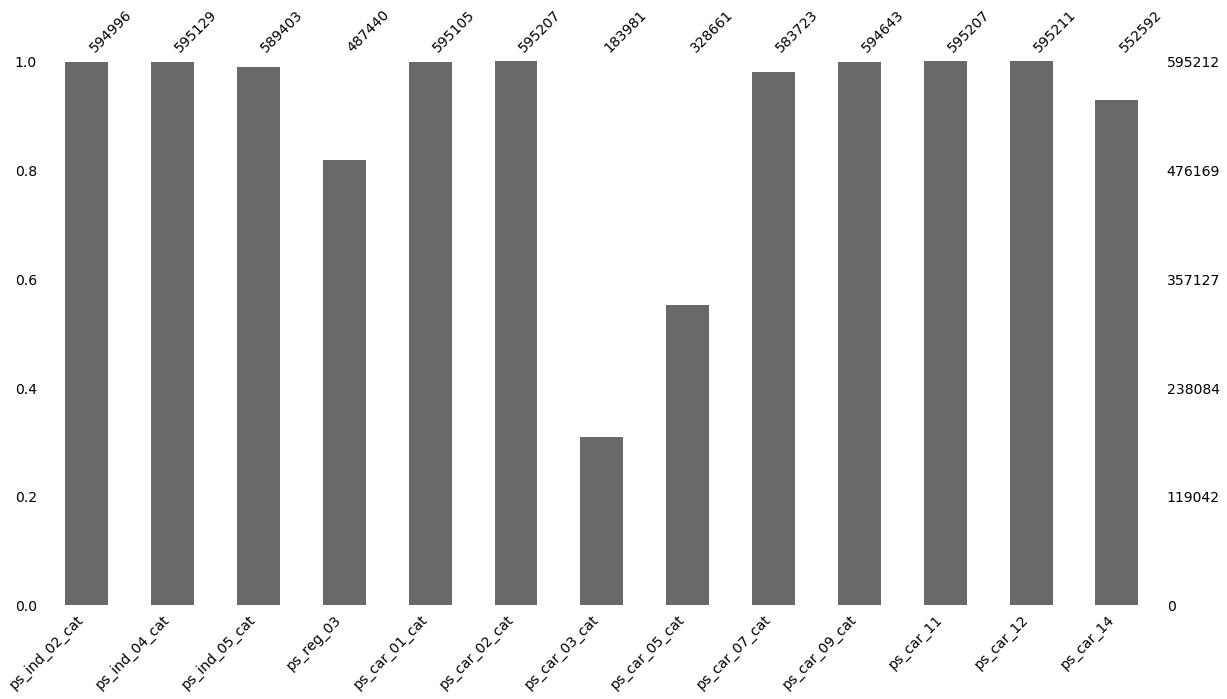

In [29]:
# show a quantidade de missing por columns
msno.bar(df_null,figsize=(20,10), fontsize=14, labels=True)

# Correlations between missing values

- É importante realizar a análise dos missing values para saber se vale a pena preencher a variável.
- Uma solução beeeem simples é determinar que `values_missing = -1`
- o que os algoritmos fazem com missing values é geralmente uma caixa preta

### Heatmap

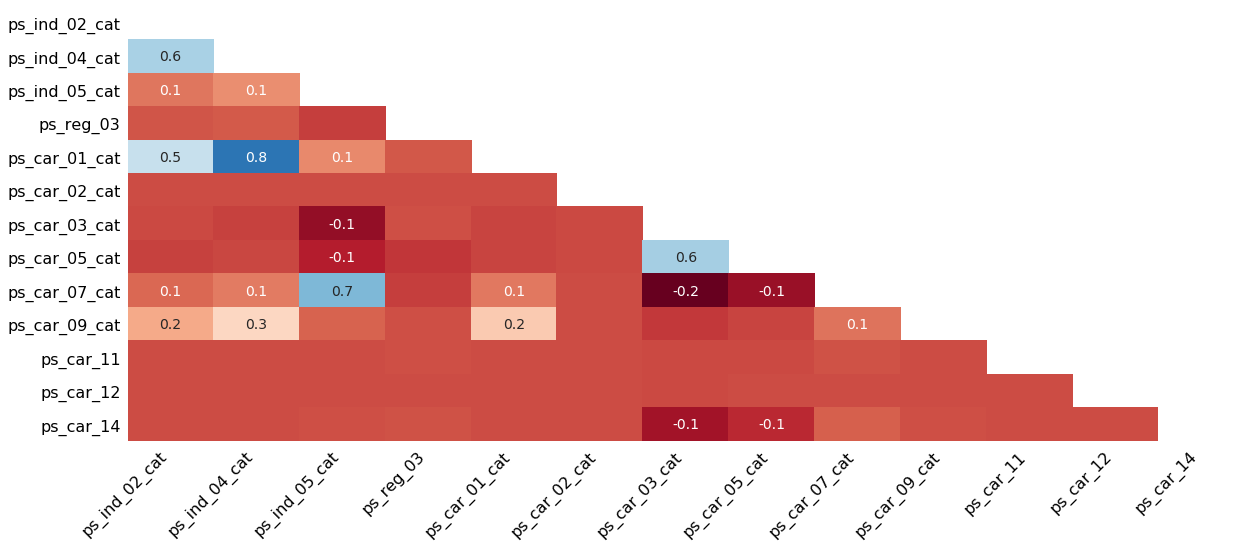

In [31]:
msno.heatmap(df_null,figsize=(20,8))

### Dendrogram
-  Denograma serve para visualizar correlações
- a profundidade (eixo y)indica a correlacao entre as variáveis
- _ps_car_01_cat_ esta altamente correlacionada com _ps_ind_04_cat_ pois (eixo Y = 0)


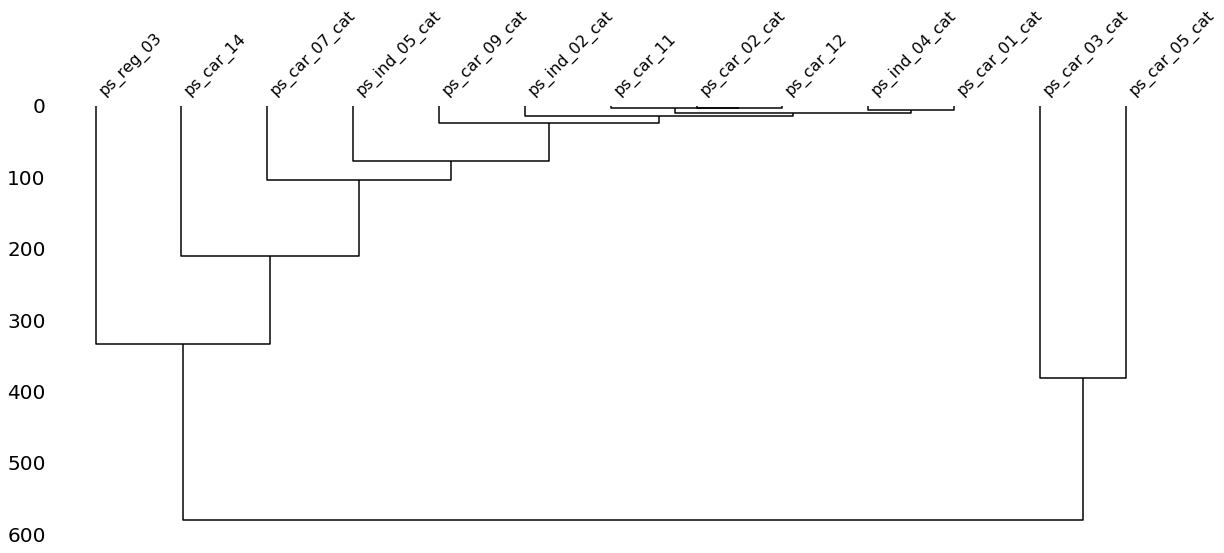

In [32]:
msno.dendrogram(df_null, figsize=(20,8))

### Gráfico das colunas
- Ajuda a entender que a distribuição de values missing por columns.

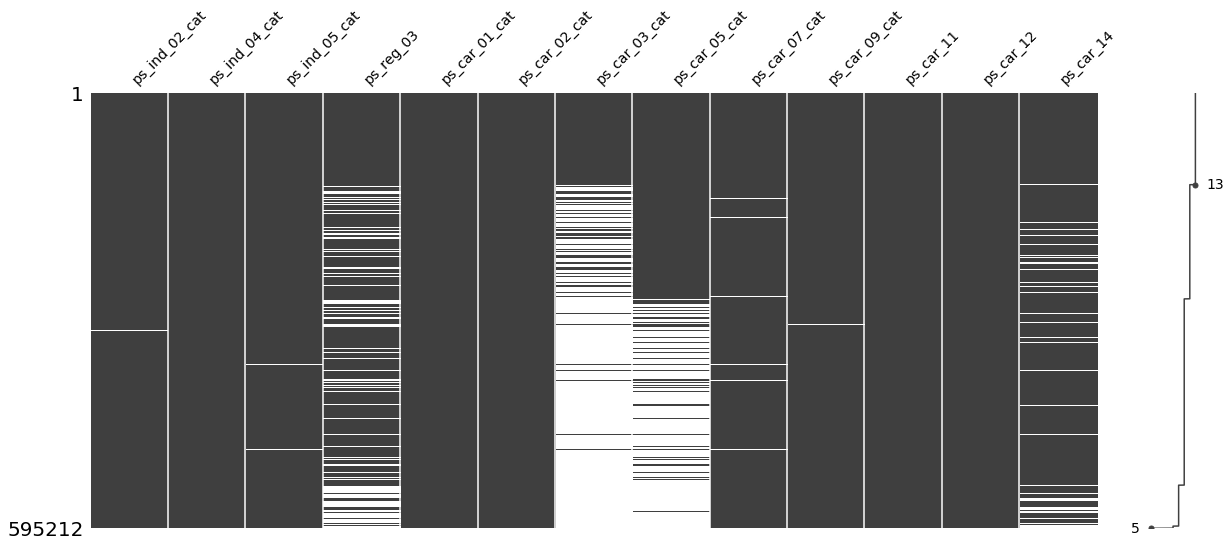

In [33]:
sorted_data = msno.nullity_sort(df_null, sort='descending')
msno.matrix(sorted_data, figsize=(20,8), fontsize=14)

### Matrix linear correlation Pearson
- if two variables = 1 so it's colinear, in this case the variables are the same thing and possibly **only have different names.**


In [35]:
display(col_internval)

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12',
       'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02',
       'ps_calc_03'],
      dtype='object', name='varname')

In [37]:
corr_matrix = train[col_internval].corr()
display(corr_matrix)

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
ps_reg_01,1.000000,0.471027,0.189040,0.077135,0.018782,0.027097,-0.002083,0.002765,-0.000891,0.002194,-0.001538
ps_reg_02,0.471027,1.000000,0.742668,0.068140,0.171453,0.194316,0.055495,0.054510,0.001347,-0.000770,0.000022
ps_reg_03,0.189040,0.742668,1.000000,0.052932,0.228926,0.264800,0.090909,0.091401,0.000837,-0.000515,0.001832
ps_car_11,0.077135,0.068140,0.052932,1.000000,0.057021,0.101886,-0.039729,0.109680,0.000117,0.001712,-0.001633
ps_car_12,0.018782,0.171453,0.228926,0.057021,1.000000,0.672014,0.603361,0.049740,-0.000721,-0.000392,0.000151
ps_car_13,0.027097,0.194316,0.264800,0.101886,0.672014,1.000000,0.459047,0.529519,0.000157,0.000040,-0.000200
ps_car_14,-0.002083,0.055495,0.090909,-0.039729,0.603361,0.459047,1.000000,0.009733,-0.003274,-0.001883,-0.001110
ps_car_15,0.002765,0.054510,0.091401,0.109680,0.049740,0.529519,0.009733,1.000000,0.000344,-0.000252,-0.001043
ps_calc_01,-0.000891,0.001347,0.000837,0.000117,-0.000721,0.000157,-0.003274,0.000344,1.000000,-0.002418,0.000526
ps_calc_02,0.002194,-0.000770,-0.000515,0.001712,-0.000392,0.000040,-0.001883,-0.000252,-0.002418,1.000000,0.002948


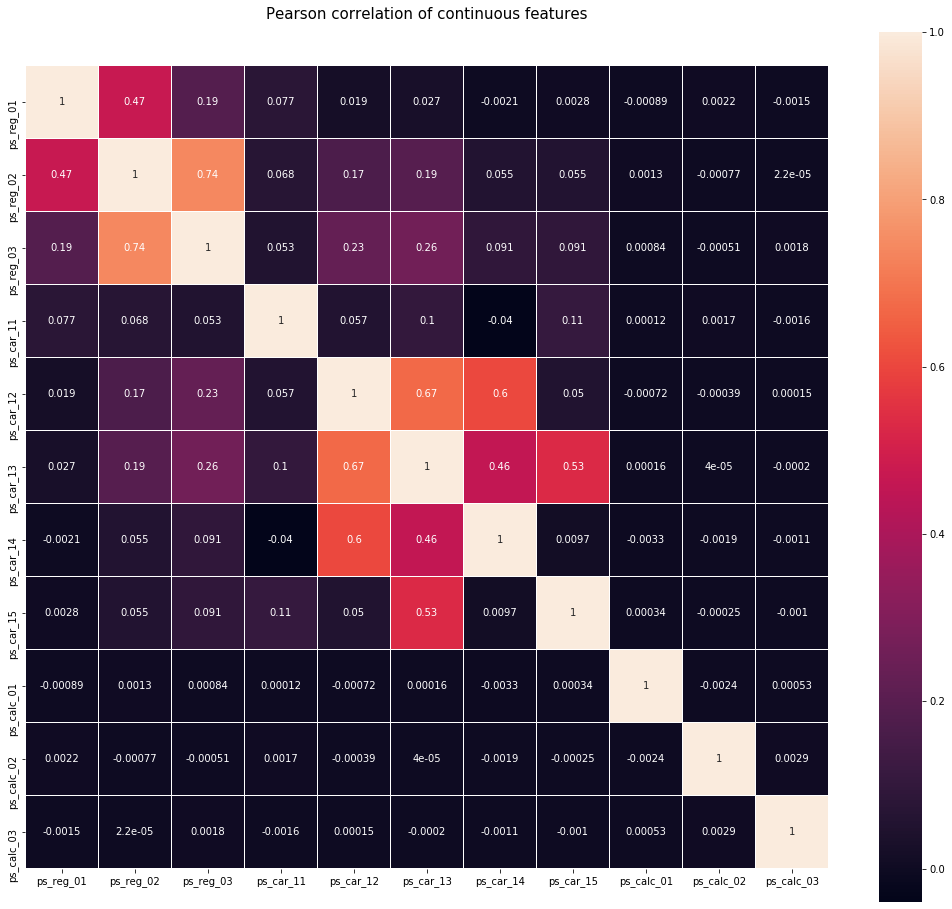

In [40]:
plt.figure(figsize=(18,16))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train[col_internval].corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            linecolor='white', 
            annot=True)

In [41]:
# preenche todos os missing values com (-1)
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

## Feature Importance
 - O principal objetivo de ter uma avaliação de feature_importance é para detectar problemas.
 - As feature_importance são analisadas encima de alguma modelo. 

In [42]:
def get_feature_importance_df(feature_importances,
                              column_names, 
                              top_n=25):
    """Get feature importance data frame.
 
    Parameters
    ----------
    feature_importances : numpy ndarray
        Feature importances computed by an ensemble 
            model like random forest or boosting
    column_names : array-like
        Names of the columns in the same order as feature 
            importances
    top_n : integer
        Number of top features
 
    Returns
    -------
    df : a Pandas data frame"""
     
    imp_dict = dict(zip(column_names, feature_importances))
    
    # get name features sroted
    top_features = sorted(imp_dict, key=imp_dict.get, reverse=True)[0:top_n]
    
    # get values
    top_importances = [imp_dict[feature] for feature in top_features]
    
    # create dataframe with feature_importance
    df = pd.DataFrame(data={'feature': top_features, 'importance': top_importances})
    return df

Vou analisar as feature_importance encima de uma random forest

In [43]:
# create model
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=150, # numbers tree
                            max_depth=8,
                            min_samples_leaf=4,
                            max_features=0.2, # each tree utility 20% in the features
                            n_jobs=-1,
                            random_state=42)

In [44]:
# trainning model
rf.fit(train.drop(['target'], axis=1), train.target)
features = train.drop(['target'], axis=1).columns.values
print("---Traing Done---")

---Traing Done---


In [45]:
print(type(features))
print(features)

<class 'numpy.ndarray'>
['id' 'ps_ind_01' 'ps_ind_02_cat' 'ps_ind_03' 'ps_ind_04_cat'
 'ps_ind_05_cat' 'ps_ind_06_bin' 'ps_ind_07_bin' 'ps_ind_08_bin'
 'ps_ind_09_bin' 'ps_ind_10_bin' 'ps_ind_11_bin' 'ps_ind_12_bin'
 'ps_ind_13_bin' 'ps_ind_14' 'ps_ind_15' 'ps_ind_16_bin' 'ps_ind_17_bin'
 'ps_ind_18_bin' 'ps_reg_01' 'ps_reg_02' 'ps_reg_03' 'ps_car_01_cat'
 'ps_car_02_cat' 'ps_car_03_cat' 'ps_car_04_cat' 'ps_car_05_cat'
 'ps_car_06_cat' 'ps_car_07_cat' 'ps_car_08_cat' 'ps_car_09_cat'
 'ps_car_10_cat' 'ps_car_11_cat' 'ps_car_11' 'ps_car_12' 'ps_car_13'
 'ps_car_14' 'ps_car_15' 'ps_calc_01' 'ps_calc_02' 'ps_calc_03'
 'ps_calc_04' 'ps_calc_05' 'ps_calc_06' 'ps_calc_07' 'ps_calc_08'
 'ps_calc_09' 'ps_calc_10' 'ps_calc_11' 'ps_calc_12' 'ps_calc_13'
 'ps_calc_14' 'ps_calc_15_bin' 'ps_calc_16_bin' 'ps_calc_17_bin'
 'ps_calc_18_bin' 'ps_calc_19_bin' 'ps_calc_20_bin']


In [46]:
# get trained model (rf) and avalible the feature_importance
feature_importance = get_feature_importance_df(rf.feature_importances_, features)

# print 25 feature_importance in the rf randomForest
feature_importance

,feature,importance
0,ps_car_13,0.130138
1,ps_ind_05_cat,0.072278
2,ps_reg_03,0.068513
3,ps_ind_17_bin,0.056633
4,ps_ind_03,0.037766
5,ps_reg_02,0.036831
6,id,0.035909
7,ps_car_07_cat,0.031743
8,ps_car_04_cat,0.027767
9,ps_car_14,0.027429


[Text(0, 0.5, 'Importance'),
 Text(0.5, 0, 'Variable name'),
 Text(0.5, 1.0, 'Variable importances')]

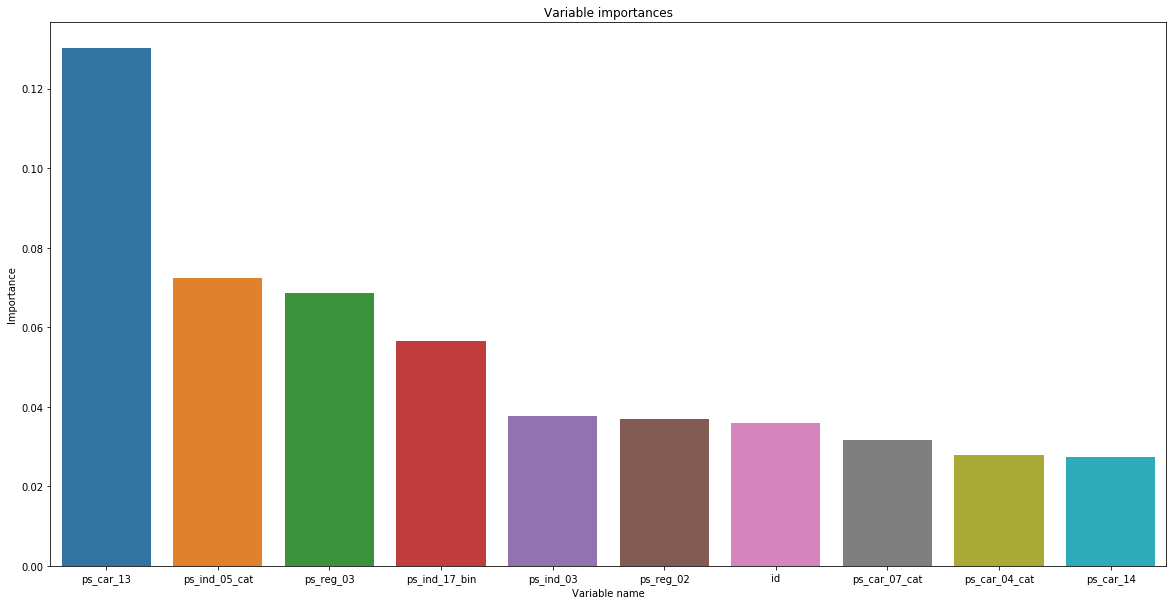

In [47]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(data=feature_importance[:10], 
            x="feature", 
            y="importance", 
            ax=ax)
ax.set(xlabel='Variable name',
       ylabel='Importance',
       title="Variable importances")

---

# Baseline models

Vou começar com um base_line, sendo o mais simples possível, então:    
- Primeiramente começar com uma abordagem mais simples possível
- missing_values = -1
- tentar olhar se há variáveis completamente vazias
- se há colinearidades entre variáveis, drop column
- entender as distribuições das variáveis
- criar modelo bem simples, como por exemplo, logistic_regression, random_forest, mediana


In [48]:
def cross_val_model(X,y, model, n_splits=3):
    'Do split dataset and calculate cross_score'
    X = np.array(X)
    y = np.array(y)
    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2017).split(X, y))

    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='roc_auc')
        print("    cross_score: %.5f" % cross_score.mean())

## Random Forest Model
- Cada tree tem seu próprio conjunto de dados e de features selecionados de modo randomico
- Random forest lida melhor com overfitting

In [49]:
#RandomForest params
rf_params = {}
rf_params['n_estimators'] = 200
rf_params['max_depth'] = 6
rf_params['min_samples_split'] = 70
rf_params['min_samples_leaf'] = 30 # end tree necessary 30 leaf
rf_params['n_jobs'] = -1 # run all process

In [50]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [51]:
# create model
rf_model = RandomForestClassifier(**rf_params)

# training model
X = train.drop('target',axis=1)
y = train['target']

In [52]:
# split dataset and calculate cross_score
cross_val_model(X, y, rf_model)

Fit RandomForestClassifier fold 1
    cross_score: 0.62468
Fit RandomForestClassifier fold 2
    cross_score: 0.60543
Fit RandomForestClassifier fold 3
    cross_score: 0.58585


## XGBoost Model
- Model very robust
- descentent gradient 
- regularization parameter: help avoid overfitting
- parallelizable

In [53]:
# XGBoost params
xgb_params = {}
xgb_params['learning_rate'] = 0.02
xgb_params['n_estimators'] = 100
xgb_params['max_depth'] = 6
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9

In [54]:
# create model
XGB_model = XGBClassifier(**rf_params)

# training model
X = train.drop('target',axis=1)
y = train['target']

In [ ]:
cross_val_model(X, y, XGB_model)

Fit XGBClassifier fold 1


In [ ]:
# garantir que as colunas do train (X) são iguais a do test
column = X.columns
test = test[column]

---

# Make submission Kaggle

In [ ]:
submission = pd.DataFrame(columns=['id', 'target'])
submission['id'] = id_test
submission['target'] = rf_model.predict_proba(test)[:, 1] # get all rows in the column 'id'
submission.to_csv('first_submission.csv', index=False)

pd.read_csv('first_submission.csv')

---

#### Copyright
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">
    <img alt="Creative Commons License" align="right" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" />
</a><br />This work by 
    <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Bruno A. R. M. Campos</span> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.